## A brief comparision between KKZ and K-Means methods - Part II

In the first study over differences between K-means and KKZ characteristics, the main features from both methods were analysed and a naive implementation from KKZ method were outlined. In this second study the objective is numerically compare the efficience between two methods in covering the global spread from a given toy dataset.

## The dataset

The same dataset employed in the first study is repeated here. Remembering, a data set with 200 random elements in the interval $[-1.0, \dots, 1.0]$ is created

In [3]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-

import numpy as np
import scipy, pylab
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist
from sklearn.datasets import make_blobs
   
dim = 2
nx = 150
ny = 1
metric = "euclidean"
seed = 1
k = 6
sample_size = 200

# This produces a numpy type from make_blobs
data = np.array(make_blobs(n_samples=sample_size,
                  n_features=dim,
                  centers=4,
                  cluster_std=1,
                  center_box=(-1.0, 1.0),
                  shuffle=True,
                  random_state=seed)[0])  # For reproducibility

In [4]:
data[1:10]

array([[-0.83661828,  0.81821277],
       [-0.28918621, -0.03055216],
       [-2.03843988, -2.57601137],
       [-0.34480386, -1.13497598],
       [ 0.14967896, -1.58155223],
       [ 0.34697383,  0.14255615],
       [-1.28326634,  0.67506468],
       [-0.3401562 , -1.85991219],
       [-1.11021828, -1.01269692]])

## K-means and KKZ methods

The K-means and KKZ methods were alread implemented in first study, and are repeated here for sake of completeness

In [7]:

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.cluster import KMeans



def kkz(data, k, metric = 'euclidian'):

    # x is our data set
    x = data
    
    # Centroids to be filled by kkz method. Dimension of k x 2 
    cent = np.empty([k, 2], dtype=float)

    # Step 0. Initialize 
    y = np.ndarray.mean(x, axis=0, keepdims=True)
    dist = cdist( y, x, metric=metric )  # -> (nx, ny) distances
    idx = dist.argmax()
    cent[0] = np.matrix(x[idx], dtype=float)
    x = np.delete(x, idx, axis=0)

    # Gets the maximum distance elements for k elements
    for i in range(1,k):
        dist = cdist(x, cent, metric=metric ) # returns x and y distance by metric
        idx = np.mean(dist, 1).argmax()
        cent[i] = np.matrix(x[idx], dtype=float)
        x = np.delete(x, idx, axis=0) # removes selected element from left points

    # Plot all data labeled by kmeans method
    plt.scatter(data[:,0], data[:,1], c="red")
    plt.title('KKZ centroids', fontsize=16)

    # Plot all KKZ "centroids" labeled by its iteration order
    plt.scatter(cent[:, 0], cent[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    
    # Labels the elements selectd as centroids 
    for i, c in enumerate(cent):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    # Shows a chart
    plt.show()
    
    # Return centroids
    return cent


def k_means(data, k):
    
    # Fitting data
    y = KMeans(n_clusters=k, random_state=seed).fit(data)

    # plotting
    plt.scatter(data[:, 0], data[:, 1], c='red')
    plt.title('K-means centroids', fontsize=16)
   
    # Draw white circles at cluster centers
    centers = y.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                c='white', alpha=1, s=200, edgecolor='k')
    
    # Labeling the clusters
    for i, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    
    # Show results
    plt.show()

    return centers

## The Elbow method

Here the question is: how to decide about the number of optimal clusters in ensemble selections problems? 

It can be found by applying the "Elbow" criterion [3]. Generally, this method consists in to apply a sequence of cluster calculations until an arbitrary upper limit $k$. In the sequence K where $K = n \in 2 \dots k$, the optimal number of elements is found when, in the step $n$, adding $n+1$ element no more represents an improvement in that metric. In this case, the stop criteria can be described as the percentage cover of the global data set variance. In this study as in its references, a good level of representation is defined as $90\%$ of coverage. 

Coverage here can be defined as the number of elements inside a convex hull built by elements selected in KKZ method as vertices. Lets apply the Elbow criterion in both cases.

Before that it necessary to create a function which returns if a given set of points are inside or outside the hull. Also the fucntion code to plot the score for posterior analysis.

In [11]:
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

def in_hull(p, hull):

    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0


def elbow_chart(score):
    plt.plot(range(2,k),score[2:k]*100, marker='o', linestyle='--', linewidth=0.8)
    plt.ylabel("coverage (%)", fontsize=11)
    plt.xlabel("Number of scenarios", fontsize=11)
    plt.title("Coverage levels", fontsize=16)
    plt.axhline(y=90, color='r', linewidth=0.5, linestyle=':')
    plt.annotate('90%', xy=(2, 90), xytext=(-5, 10), textcoords='offset points', ha='left', va='top', color='r')
    plt.show()

## Results

Then, given an arbitrary number of possible elements fitting your objetives (lets say k = 8), it is necessary run multiple simulations to achieve the minimal set of elements which permits to cover better the total spread of original dataset. The code will, incrementally, generate 5 charts with the selected elements for each step. At the end, the Elbow diagram showing the number of elements required to cover over 90% of dataset's spread.

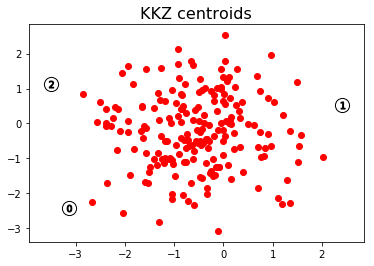

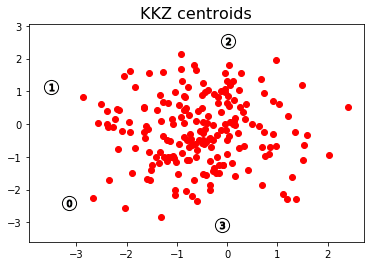

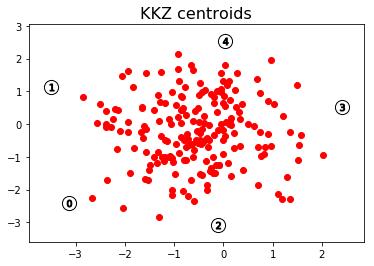

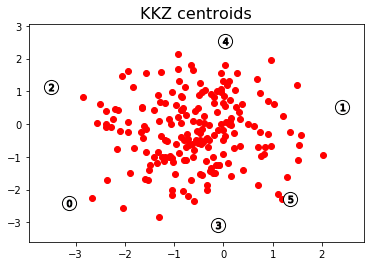

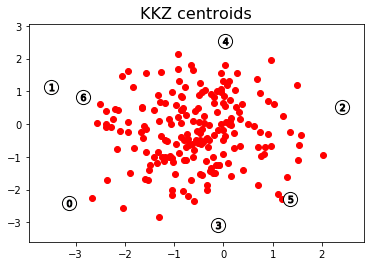

In [12]:
import numpy as np

k = 8
score = np.empty(k, dtype=float)

#  A minimal possible convex hull has 3 vertex
for i in range(3,k):
        kkz_centroids = kkz(data, i, metric)
        tmp = float(np.count_nonzero(in_hull(data, kkz_centroids)))
        score[i] = tmp/sample_size


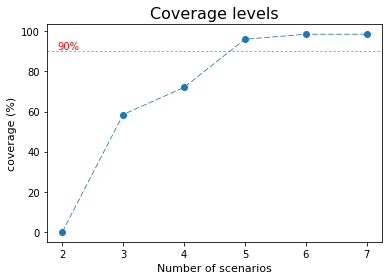

In [13]:
elbow_chart(score)

The Elbow chart above shows that the limite of 90% of coverage is trespassed for 5 elements. Also means that beyond 5 elements there are no significant improvemente in characterize the spread of dataset.

## Conclusions

This study overviews the main differences when selecting centroids from K-means and KKZ methods. Historically, K-means has been applied in the context of dimensionality reduction in ensembles of models. In these cases, more than to selecting representative centroids in high density clusters (subject where K-means works explendid), the aim is to select centroids which better represents extreme scenarios in a high dimentional spaces at low cpu-time cost and in an incremental way. 

As demonstrated in the toy dataset, it is possible to represent 90% of the spread of 200 elements with only 5 elements wisely choosen by the method. In an climate research experiment it means a reduction in -97% of hot storage data requirement when performing the research as well as significant time improvements of man/hour dedication required by development and treatment of data complexity. 

## Bibliography